## I. Libraries

In [ ]:
import numpy as np
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd

In [ ]:
pip install py_vollib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 130 kB 21.6 MB/s 
  Created wheel for py-vollib: filename=py_vollib-1.0.1-py3-none-any.whl size=62855 sha256=14e6403a83f4874e33d86d2c4be5dda8cb147b280d2f947993019a1bd09d0171
  Stored in directory: /root/.cache/pip/wheels/2d/25/50/bc80b93c9a827ed9bef9d86f85365e1934bcbc0666b9f00c11
  Created wheel for py-lets-be-rational: filename=py_lets_be_rational-1.0.1-py3-none-any.whl size=24470 sha256=6fa997ed12a3400e4b196f4f46c869b4e2861b51afa77333b0d770051dfd8e46
  Stored in directory: /root/.cache/pip/wheels/1a/70/10/bf54a16badc528594c9510ef517badb765a29b651ea5652898
Successfully built py-vollib py-lets-be-rational


In [ ]:
import py_vollib.black_scholes as bs

## II. Find Numerical Approximation

### (a) Using Fully Implicit Method

Suppose that

$V(S, t)$ gives the value of the option at time t given that $S_t = S$

Let $x = log(S)$, we get a function $f(x, t)$ which gives the same result as $V(S, t)$ but takes different input. That is to say the approximation of $f(.)$ is also the approximation of $V(.)$

The following function approximates $f(x, t)$ by _fully implicit discretization method_

In [ ]:
def fully_implicit_approx(S0 = 100, K = 100, r = 0.02, T = 1, sigma = 0.15, N = 1000, M = 1000,
                          getf = False):
    """
    This function use fully implicit method to approximate the price of an option 
    given parameters to Black-Scholes pricing formula.
    
    Arguments:
     - Parameters for Black-Scholes formula (S0, K, sigma, r, T)
     - Parameters for implicit discretization:
         +) N [int] number of subintervals in log-price (x_T = log(S_T)) domain
         +) M [int] number of subintervals in time domain
    - Others:
         +) getF [bool] whether to get the result grid of approximation of (modified) BS PDE
    
    Return:
    - f_S0 [float] Price of the option at given S0 and other BS parameters
    - (Optional) f [matrix] The approximations of BS PDE in the grid
    
    """

    #------------(1) Discretize the domains------------
    # Time domain
    Ti, dt = np.linspace(0, T, M, retstep = True)
    # Log-price domain
    x_min = np.log(K/3)
    x_max = np.log(3*K)
    x, dx = np.linspace(x_min, x_max, N, retstep = True)

    
    #------------(2) Initialize the approximation grid F ------
    f = np.zeros((N, M))
    #----------- By the terminal condition: F(S, t = T) = payoff given S
    payoff_at_T = np.maximum(K - np.exp(x), 0)
    f[:, -1] = payoff_at_T

    #----------- By the boundary condition (1) F(S = Smin, t) = payoff given S = Smin at time t
    f[0, :] = K*np.exp(-r*Ti[::-1]) - np.exp(x_min)
    #----------- By the boundary condition (2) F(S = Smax, t) = payoff given S = Smax at time t
    f[-1, :] = 0


    #------------(3) Construct coefficient matrix A-------------
    sig2 = sigma**2
    dxx = dx * dx

    a = ( (dt/2) * ( (r-0.5*sig2)/dx - sig2/dxx ) )
    b = ( 1 + dt * ( sig2/dxx + r ) )
    c = (-(dt/2) * ( (r-0.5*sig2)/dx + sig2/dxx ) )

    col_0 = np.concatenate([[b, a],
                            np.zeros(N-2-2)])
    row_0 = np.concatenate([[b, c],
                            np.zeros(N-2-2)])
    
    A = toeplitz(col_0, row_0)

    #------------(4) Initialize the column vector g----------
    g = np.zeros(N-2)

    #------------(5) Solve for F by backward approximation
    for j in range(M-2, -1, -1):
      g[0] = a*f[0, j]
      g[-1] = c*f[-1, j]
      f[1:-1, j] = np.linalg.solve(A, f[1:-1, j+1] - g)
    #------------(6) Calculate the price at the given S0--------
    # Since we have obtained the approximation grid, we can use the
    # result of approximated option price at time t = 0 as base points
    # to interpolate the price of option at given S0
    x0 = np.log(S0) 
    f_x0 = np.interp(x0, x, f[:,0])

    if getf:
      return f_x0, f 
    
    return f_x0

### (b) Using the Crank Nicolson Method

In [ ]:
def crank_nicolson_approx(S0 = 100, K = 100, r = 0.02, T = 1, sigma = 0.15, N = 1000, M = 1000,
                          getf = False):
  
  Ti, dt = np.linspace(0, T, N+1, retstep = True)

  x_min = np.log(K/3)
  x_max = np.log(3*K)
  x, dx = np.linspace(x_min, x_max, M+1, retstep = True)

  f = np.zeros((M+1,N+1))
  payoff_at_T = np.maximum(K - np.exp(x), 0)
  f[:,-1] = payoff_at_T

  f[0,:] = (K*np.exp(-r*Ti[::-1]) - np.exp(x_min))
  f[-1,:] = 0

  sig2 = sigma**2

  j = np.arange(0, M+1)

  a = (dt/4) * (sig2*j**2 - 0.02*j)
  b = (-dt/2) * (sig2*j**2 + 0.02)
  c = (dt/4) * (sig2*j**2 + 0.02*j) 

  b_from1 = 1 - b
  b_plus1 = 1 + b

  C = -np.diag(a[2:M], -1) + np.diag(b_from1[1:M]) - np.diag(c[1:M-1],1)
  D = np.diag(a[2:M], -1) + np.diag(b_plus1[1:M]) + np.diag(c[1:M-1],1)

  Ki = np.zeros(999)
  Kip1 = np.zeros(999)

  for i in range(N-1, -1, -1):
    Ki[0] = a[1] * f[0,i]
    Ki[-1] = c[-2] * f[-1, i]
    
    Kip1[0] = a[1] * f[0,i+1]
    Kip1[-1] = c[-2] * f[-1, i + 1]
    
    f[1:-1, i] = np.linalg.solve(C, np.matmul(D, f[1:-1, i+1]) + Ki + Kip1)

  x0 = np.log(S0) 
  f_x0 = np.interp(x0, x, f[:,0])

  return f_x0

## III. Compare with the values obtained by Black-Scholes pricing formula

### (1) Prices obtained by approximation

#### a. Fully Implicit

In [ ]:
K = np.arange(60, 141, 10)
K

array([ 60,  70,  80,  90, 100, 110, 120, 130, 140])

In [ ]:
sigma = np.array([0.15, 0.30, 0.50])
sigma

array([0.15, 0.3 , 0.5 ])

In [ ]:
f_FI = np.zeros((K.shape[0], sigma.shape[0]))
n_K = K.shape[0]
n_sigma = sigma.shape[0]
for i in range(n_K):
  for j in range(n_sigma):
    f_FI[i, j] = fully_implicit_approx(S0 = 100, K = K[i], r = 0.02,
                                              T = 1, sigma = sigma[j])

In [ ]:
f_FI

array([[5.86184135e-04, 3.51964512e-01, 2.77658519e+00],
       [2.41169407e-02, 1.23312898e+00, 5.30244922e+00],
       [2.93346088e-01, 3.11348585e+00, 8.80432660e+00],
       [1.58655221e+00, 6.28575002e+00, 1.32526938e+01],
       [4.98109901e+00, 1.08399650e+01, 1.85683392e+01],
       [1.08881149e+01, 1.66846915e+01, 2.46488161e+01],
       [1.87784888e+01, 2.36206328e+01, 3.13860443e+01],
       [2.78048364e+01, 3.14136117e+01, 3.86766493e+01],
       [3.73386411e+01, 3.98435645e+01, 4.64273524e+01]])

#### b. Crank-Nicolson

In [ ]:
f_CN = np.zeros((K.shape[0], sigma.shape[0]))
n_K = K.shape[0]
n_sigma = sigma.shape[0]
for i in range(n_K):
  for j in range(n_sigma):
    f_CN[i, j] = crank_nicolson_approx(S0 = 100, K = K[i], r = 0.02,
                                              T = 1, sigma = sigma[j])

In [ ]:
f_CN

array([[1.28513761e-02, 8.78589194e-01, 3.57829734e+00],
       [1.03652458e-01, 1.91305230e+00, 5.77964966e+00],
       [5.31315078e-01, 3.66917007e+00, 8.58257309e+00],
       [1.89370625e+00, 6.37105936e+00, 1.20552119e+01],
       [5.02242370e+00, 1.02002279e+01, 1.62492468e+01],
       [1.04879799e+01, 1.52604524e+01, 2.11976843e+01],
       [1.81462186e+01, 2.15558545e+01, 2.69131348e+01],
       [2.72644511e+01, 2.89898495e+01, 3.33872119e+01],
       [3.70601040e+01, 3.73836521e+01, 4.05899435e+01]])

### (2) Price obtained by Black-Scholes formula

In [ ]:
import numpy as np
from scipy.stats import norm


K = np.arange(60, 141, 10)
r = 0.02
T = 1
sigma = np.array([0.15, 0.30, 0.50])
S = 100


N = norm.cdf


def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    return K*np.exp(-r*T)*N(-d2) - S*N(-d1)


f_BS = np.zeros((n_K, n_sigma))
for i in range(n_K):
  for j in range(n_sigma):
    f_BS[i, j] = BS_PUT(S = 100, K = K[i], r = 0.02,
                        T = 1, sigma = sigma[j])





In [ ]:
f_BS

array([[5.74590578e-04, 3.51561496e-01, 2.78015191e+00],
       [2.39970947e-02, 1.23298237e+00, 5.30450841e+00],
       [2.93175413e-01, 3.11403723e+00, 8.80649070e+00],
       [1.58680137e+00, 6.28694286e+00, 1.32551910e+01],
       [4.98170898e+00, 1.08414487e+01, 1.85710581e+01],
       [1.08883216e+01, 1.66860100e+01, 2.46515749e+01],
       [1.87780172e+01, 2.36214130e+01, 3.13887109e+01],
       [2.78041895e+01, 3.14137708e+01, 3.86792686e+01],
       [3.73381813e+01, 3.98431635e+01, 4.64301480e+01]])

### (3) Compare

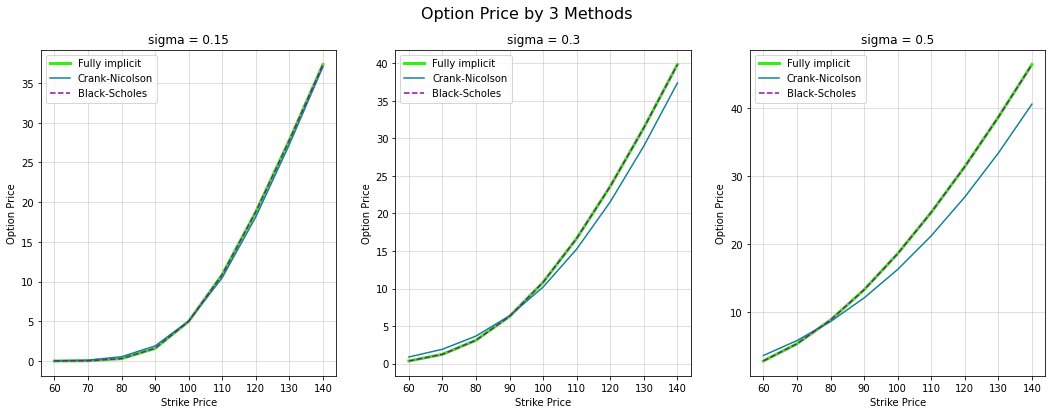

In [ ]:
fig = plt.figure(figsize = (18, 6))
fig.suptitle('Option Price by 3 Methods', size = 16)
for i in range(n_sigma):
  ax = fig.add_subplot(1, 3, i+1)
  ax.set_title(f'sigma = {sigma[i]}')

  ax.set_xlabel('Strike Price')
  ax.set_ylabel('Option Price')

  ax.plot(K, f_FI[:,i], label = 'Fully implicit', lw = 3, color = '#31F10E')
  ax.plot(K, f_CN[:,i], label = 'Crank-Nicolson', color = '#128295')
  ax.plot(K, f_BS[:,i], label = 'Black-Scholes', color = '#8E0FA4', linestyle = '--')
  ax.grid(True, alpha = 0.5)
  ax.legend()



plt.show()

In [ ]:
index1 = np.concatenate([np.full(n_K, sigma[0]),
                         np.full(n_K, sigma[1]),
                         np.full(n_K, sigma[2])])
index2 = np.concatenate([K, K, K])

In [ ]:
pd.DataFrame({'Black-Scholes': f_BS.flatten('F'),
              'Fully Implicit': f_FI.flatten('F'),
              'Crank_Nicolson': f_CN.flatten('F')},
             index = [index1, index2])

Black-Scholes  Fully Implicit  Crank_Nicolson
0.15 60        0.000575        0.000586        0.012851
     70        0.023997        0.024117        0.103652
     80        0.293175        0.293346        0.531315
     90        1.586801        1.586552        1.893706
     100       4.981709        4.981099        5.022424
     110      10.888322       10.888115       10.487980
     120      18.778017       18.778489       18.146219
     130      27.804190       27.804836       27.264451
     140      37.338181       37.338641       37.060104
0.30 60        0.351561        0.351965        0.878589
     70        1.232982        1.233129        1.913052
     80        3.114037        3.113486        3.669170
     90        6.286943        6.285750        6.371059
     100      10.841449       10.839965       10.200228
     110      16.686010       16.684691       15.260452
     120      23.621413       23.620633       21.555855
     130      31.413771       31.413612       28.989850
     140      39.843163       39.843565       37.383652
0.50 60        2.780152        2.776585        3.578297
     70        5.304508        5.302449        5.779650
     80        8.806491        8.804327        8.582573
     90       13.255191       13.252694       12.055212
     100      18.571058       18.568339       16.249247
     110      24.651575       24.648816       21.197684
     120      31.388711       31.386044       26.913135
     130      38.679269       38.676649       33.387212
     140      46.430148       46.427352       40.589943